In [2]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import time

# CNN_RNN


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, LSTM
from sklearn.model_selection import KFold
import time

# Define constants
IMAGE_SIZE = (96, 72)
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 17  # Update this to the correct number of classes in your dataset
TRAIN_DATA_DIR = "C:\\Users\\sumit\\Downloads\\Noise reduction 2\\output_denoised_image_folder"
K_FOLDS = 5

# Load the data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
data_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Validation data generator
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# Initialize KFold
kf = KFold(n_splits=K_FOLDS, shuffle=True)

# Initialize arrays to store accuracies and computational times
train_accuracies = []
val_accuracies = []

comp_times = []

# Define the CNN-RNN model
model = Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Reshape((8, 128)),
    LSTM(256),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 339 images belonging to 17 classes.
Found 78 images belonging to 17 classes.


In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 70, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 35, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 33, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 16, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 14, 256)       590080    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 7, 256)       0

In [4]:
# Track start time
start_time = time.time()

# K-fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(data_generator), 1):
    train_generator = datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        subset='training',
        seed=42
    )

    validation_generator = datagen.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation',
        seed=42
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        verbose=1
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(validation_generator)

    print(f"Fold {fold}:")
    print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")
    print(f"Training time for fold {fold}: {time.time() - start_time} seconds\n")

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    comp_times.append(time.time() - start_time)

    # Save the model for this fold
    model.save(f'cnn-rnn_kfold({K_FOLDS})_{fold}.h5')

# Track end time
end_time = time.time()

print("K-Fold Cross Validation Complete.")
# Print average accuracies and computational time
print("Average Training Accuracy:", np.mean(train_accuracies)*100,"%")
print("Average Validation Accuracy:", np.mean(val_accuracies)*100,"%")
print("Average Training Time:", np.mean(comp_times))
print("Total Training Time:", end_time - start_time)


Found 339 images belonging to 17 classes.
Found 78 images belonging to 17 classes.
Epoch 1/100
21/21 [==============================] - 12s 133ms/step - loss: 2.8653 - accuracy: 0.0526 - val_loss: 2.8331 - val_accuracy: 0.0781
Epoch 2/100
21/21 [==============================] - 1s 34ms/step - loss: 2.8345 - accuracy: 0.0619 - val_loss: 2.8333 - val_accuracy: 0.0781
Epoch 3/100
21/21 [==============================] - 1s 34ms/step - loss: 2.8317 - accuracy: 0.0743 - val_loss: 2.8348 - val_accuracy: 0.0781
Epoch 4/100
21/21 [==============================] - 1s 34ms/step - loss: 2.8322 - accuracy: 0.0712 - val_loss: 2.8359 - val_accuracy: 0.0781
Epoch 5/100
21/21 [==============================] - 1s 33ms/step - loss: 2.8311 - accuracy: 0.0650 - val_loss: 2.8359 - val_accuracy: 0.0781
Epoch 6/100
21/21 [==============================] - 1s 35ms/step - loss: 2.8303 - accuracy: 0.0714 - val_loss: 2.8337 - val_accuracy: 0.0781
Epoch 7/100
21/21 [==============================] - 1s 34ms/st

# Training accuracy

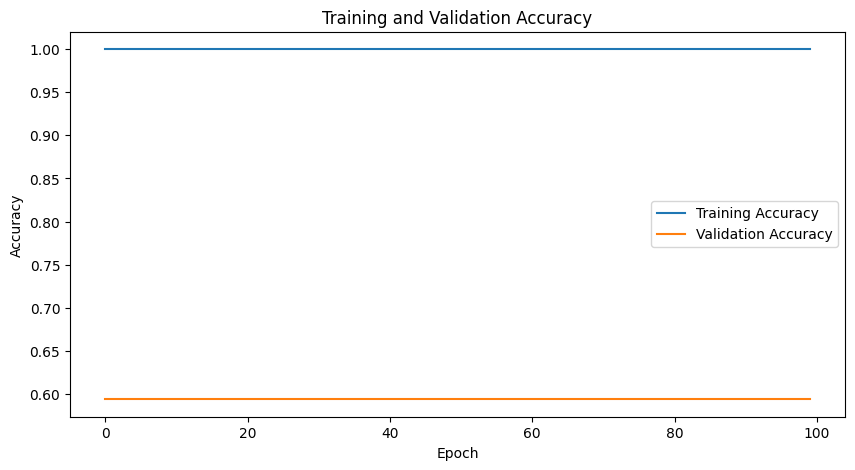

In [5]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC CURVE

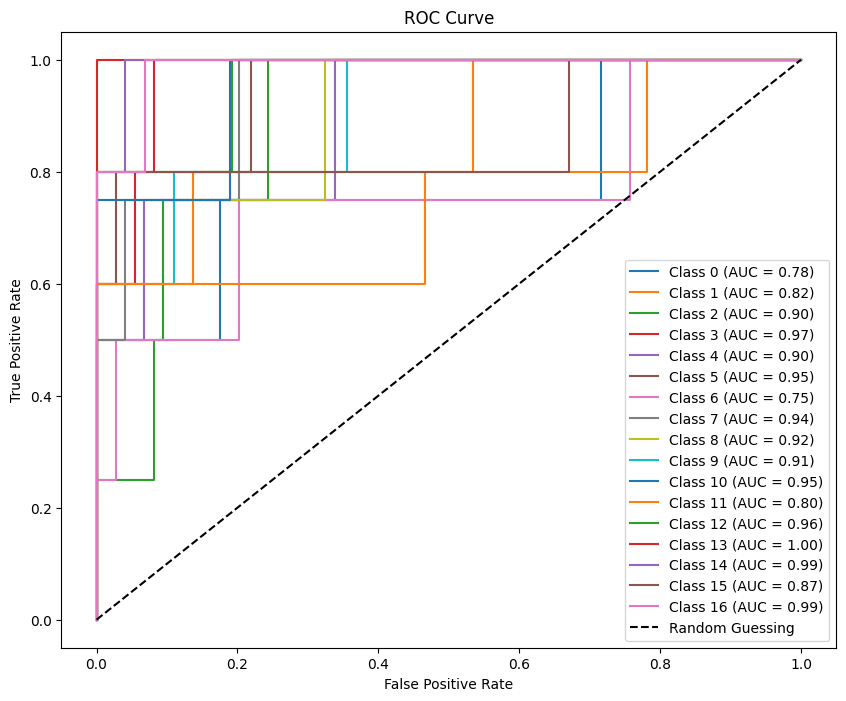

In [6]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix

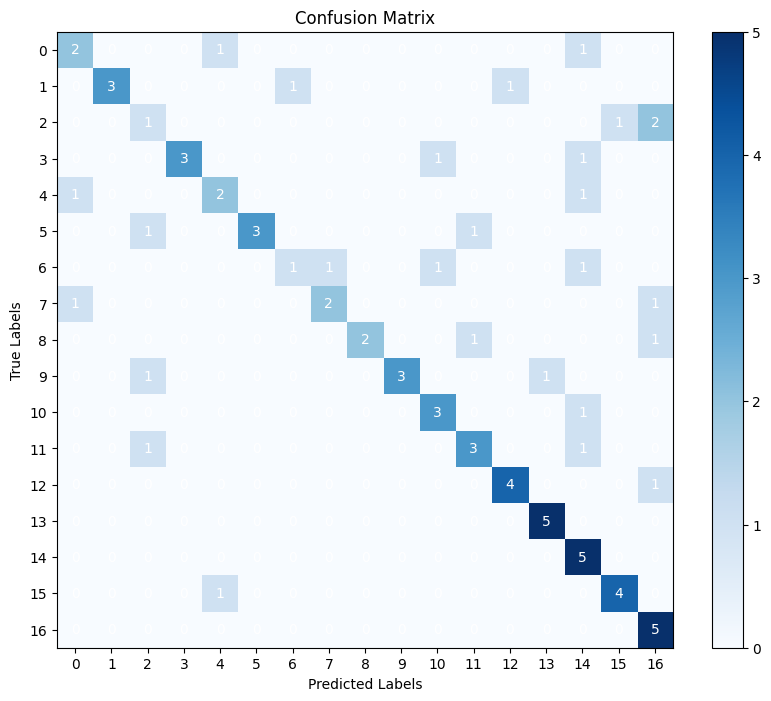

In [7]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()


# F1 score support

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd
import time

# Assuming you already have the necessary variables defined in your code
train_predictions = model.predict(train_generator)
validation_predictions = model.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# ... (your existing code)

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': list(train_generator.class_indices.keys()),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': list(validation_generator.class_indices.keys()),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'combined_metricsCNN-RNNkfold5.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")



NameError: name 'model' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd

# Assuming you already have the necessary variables defined in your code
train_predictions = model.predict(train_generator)
validation_predictions = model.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# ... (your existing code)

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': list(train_generator.class_indices.keys()),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': list(validation_generator.class_indices.keys()),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'k_foldvalidation5cnn.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")

In [67]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator object
# datagen = ImageDataGenerator(rescale=1./255)

# # Create a generator
# generator = datagen.flow_from_directory(
#     'D:\\New Dataset Lip Movement Projec\\FINAL YEAR PROJECT\\output_denoised_image_folder',
#     target_size=(150, 150),
#     batch_size=16,
#     class_mode='binary'
# )

# print(generator.batch_size)


Found 298 images belonging to 17 classes.
16
